## Module 1 - Introduction, Imbalanced Learning and Anomaly Detection

### Data exploration and simple classification
Explore and prepare the dataset. You are allowed to take inspiration from the associated GitHub repository and figure out your personal research perspective (from choosing a subset of variables to the class to predict…). You are welcome in creating new variables and performing all the pre-processing steps the dataset needs.
Define one or more (simple) classification tasks and solve it with Decision Tree and KNN. You decide the target variable.

In [19]:
import os
import sys
import seaborn as sns
import matplotlib.image as mpimg

import graphviz
from dtreeviz.trees import dtreeviz
from sklearn.metrics import classification_report
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from treelib import Node, Tree
from tqdm.auto import tqdm, trange
from imblearn.pipeline import make_pipeline

import utils

plt.rcParams['figure.figsize'] = (8, 4)

In [2]:
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

In [50]:
# 15 = Electronic
parent_genre = 15

selected_genres = genres.index[genres["parent"] == parent_genre].tolist()
selected_genre_names = {genres["title"].loc[idx]: idx for idx in selected_genres}
class_names = list(selected_genre_names.keys())
selected_genre_names

{'Ambient Electronic': 42,
 'Techno': 181,
 'House': 182,
 'Glitch': 183,
 'Minimal Electronic': 184,
 'Breakcore - Hard': 185,
 'IDM': 236,
 'Trip-Hop': 286,
 'Dance': 296,
 'Chip Music': 297,
 'Drum & Bass': 337,
 'Dubstep': 468,
 'Downtempo': 495,
 'Jungle': 695}

In [18]:
for i in range(3):
    print(sorted({c[i] for c in features.columns}))
    
    o riccardo.guidotti@unipi.it salvatore.citraro@phd.unipi.it

['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse', 'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast', 'spectral_rolloff', 'tonnetz', 'zcr']
['kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


In [5]:
pbar = tqdm(tracks['track'].iterrows(), total = len(tracks))

selected_tracks = [(ri, [1. if g in row['genres_all'] else 0. for g in selected_genres])
                   for ri, row in pbar if np.any([g in row['genres_all'] for g in selected_genres])]
#selected_tracks = [(ri, [1. if g == row['genre_top'] else 0. for g in selected_genre_names]) 
#                   for ri, row in pbar if str(row['genre_top']) != 'nan']

selected_data = \
    features.loc[[idx for idx, _ in selected_tracks], 
                 (("mfcc", "spectral_contrast", "spectral_centroid"), 
                  ('kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std'))
                ]

splits = tracks.loc[[idx for idx, _ in selected_tracks], (('set'), ('split'))].reset_index(drop=True)
splits = {subset: splits.index[splits == subset] for subset in ['training', 'validation', 'test']}

X = selected_data.to_numpy()
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)
y = np.stack([np.argmax(g) for _, g in selected_tracks])

X_train, X_validation, X_test = X[splits['training']], X[splits['validation']], X[splits['test']]
y_train, y_validation, y_test = y[splits['training']], X[splits['validation']], y[splits['test']]

  0%|          | 0/106574 [00:00<?, ?it/s]

In [47]:
X_train.shape, X_validation.shape, X_test.shape

((14734, 196), (2254, 196), (2141, 196))

In [73]:
def evaluate_clf(clf_class, kwargs_list, X_train, y_train, X_test, y_test, n_trials=1, sampler_class=None):
    clrs = sns.color_palette("husl", 5)
    clf = None
    scores = np.zeros((n_trials, len(kwargs_list)))
    with trange(len(kwargs_list*n_trials)) as pbar:
        for trial_i in range(n_trials):
            scores_ = []
            scoring_fun = sklearn.metrics.make_scorer(lambda X, y: sklearn.metrics.f1_score(X, y, average='macro'))
            for kwargs in kwargs_list:
                if sampler_class is not None and sampler_class!='balanced':
                    clf = make_pipeline(sampler_class(random_state=trial_i), clf_class(random_state=trial_i, **kwargs))
                else:
                    clf = clf_class(**kwargs, class_weight=sampler_class)
                clf.fit(X_train, y_train)
                scores_.append(scoring_fun(clf, X_test, y_test))
                pbar.update(1)
            scores[trial_i] = np.array(scores_)
    means = np.mean(scores, axis=0)
    stds = np.std(scores, axis=0)
    print(f'max score: {np.max(means)} ({kwargs_list[np.argmax(means)]})')
    if len(kwargs_list[0]) == 1 and len(means)>1:
        xs = np.array([list(kwargs.values())[0] for kwargs in kwargs_list])
        plt.plot(xs, means)
        plt.fill_between(xs, means-stds, means+stds, alpha=0.3)
        plt.xlabel(list(kwargs_list[0].keys())[0])
        plt.ylabel('F1 macro score')
    return clf

In [56]:
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0.))

                    precision    recall  f1-score   support

Ambient Electronic       0.36      0.73      0.48       554
            Techno       0.19      0.28      0.22       206
             House       0.04      0.01      0.02        92
            Glitch       0.15      0.16      0.15       283
Minimal Electronic       0.00      0.00      0.00        75
  Breakcore - Hard       0.25      0.02      0.03        60
               IDM       0.08      0.04      0.05       170
          Trip-Hop       0.19      0.11      0.14       156
             Dance       0.09      0.04      0.05       112
        Chip Music       0.56      0.35      0.43       228
       Drum & Bass       0.00      0.00      0.00         9
           Dubstep       0.07      0.02      0.03        56
         Downtempo       0.00      0.00      0.00       113
            Jungle       0.00      0.00      0.00        27

          accuracy                           0.29      2141
         macro avg       0.14      0.1

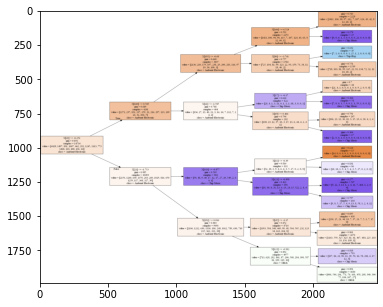

In [22]:
import graphviz

clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
dot_data = sklearn.tree.export_graphviz(clf, out_file=None, rotate=True,
                                #feature_names=iris.feature_names,  
                                class_names=class_names,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph.render(filename='images/DT_0')
imgplot = plt.imshow(mpimg.imread('images/DT_0.png'))


In [51]:
clf = KNeighborsClassifier(n_neighbors=30)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0.))

                    precision    recall  f1-score   support

Ambient Electronic       0.41      0.75      0.53       554
            Techno       0.22      0.25      0.23       206
             House       0.02      0.01      0.01        92
            Glitch       0.16      0.20      0.18       283
Minimal Electronic       1.00      0.01      0.03        75
  Breakcore - Hard       0.17      0.02      0.03        60
               IDM       0.09      0.05      0.07       170
          Trip-Hop       0.22      0.23      0.22       156
             Dance       0.09      0.04      0.06       112
        Chip Music       0.64      0.43      0.51       228
       Drum & Bass       0.00      0.00      0.00         9
           Dubstep       0.00      0.00      0.00        56
         Downtempo       0.00      0.00      0.00       113
            Jungle       0.00      0.00      0.00        27

          accuracy                           0.32      2141
         macro avg       0.22      0.1

### Outlier detection
Identify the top 1\% outliers: adopt at least three different methods from different families (e.g., density-based, angle-based… ) and compare the results. Deal with the outliers by removing them from the dataset or by treating the anomalous variables as missing values and employing replacement techniques. In this second case, you should check that the outliers are not outliers anymore. Justify your choices in every step.

In [65]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

  0%|          | 0/100 [00:00<?, ?it/s]

max score: 0.12179021886946802 ({'max_depth': 16})
14734  ->  14587


  0%|          | 0/100 [00:00<?, ?it/s]

max score: 0.123581835523535 ({'max_depth': 15})
14734  ->  14587


  0%|          | 0/100 [00:00<?, ?it/s]

max score: 0.12478129768270825 ({'max_depth': 16})
14734  ->  14587


  0%|          | 0/100 [00:00<?, ?it/s]

max score: 0.12466444955905791 ({'max_depth': 10})


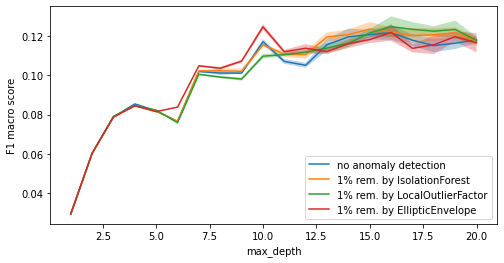

In [83]:
plt.figure(figsize=(8, 4))
md_range = range(1, 21)#71)
n_trials = 5
outlier_fraction = 0.01
evaluate_clf(DecisionTreeClassifier, [{'max_depth': i} for i in md_range], X_train, y_train, X_test, y_test, n_trials)

for od_clf in [IsolationForest(random_state=0), LocalOutlierFactor(novelty=True), EllipticEnvelope()]:
    od_clf.fit(X_train)
    inliers_train = np.argsort(od_clf.decision_function(X_train))[int(outlier_fraction*len(X_train)):]
    X_train_OD, y_train_OD = X_train[inliers_train], y_train[inliers_train]
    print(len(X_train), ' -> ', len(X_train_OD))
    evaluate_clf(DecisionTreeClassifier, [{'max_depth': i} for i in md_range], X_train_OD, y_train_OD, X_test, y_test, n_trials)

plt.legend(['no anomaly detection', '1% rem. by IsolationForest', 
            '1% rem. by LocalOutlierFactor', '1% rem. by EllipticEnvelope'])
plt.show()

### Imbalanced learning
Analyze the value distribution of the class to predict with respect to point 2; if it is unbalanced leave it as it is, otherwise turn the dataset into an imbalanced version (e.g., 96\% - 4\%, for binary classification). Then solve the classification task using the Decision Tree or the KNN by adopting various techniques of imbalanced learning.
Draw your conclusions about the techniques adopted in this analysis.

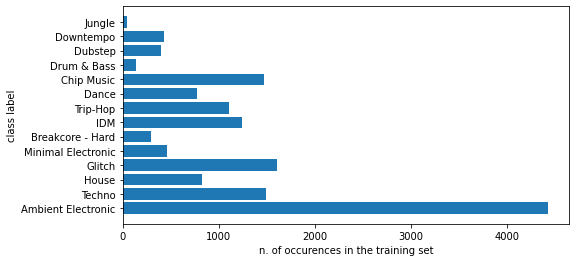

In [123]:
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 4))
plt.barh([list(selected_genre_names.keys())[idx] for idx in unique], counts)
plt.ylabel('class label')
plt.xlabel('n. of occurences in the training set')
plt.show()

14734  ->  14587


  0%|          | 0/100 [00:00<?, ?it/s]

max score: 0.1265037240709214 ({'max_depth': 16})


  0%|          | 0/100 [00:00<?, ?it/s]

max score: 0.13393881994263485 ({'max_depth': 20})


  0%|          | 0/100 [00:00<?, ?it/s]

max score: 0.13519916476814203 ({'max_depth': 14})


  0%|          | 0/100 [00:00<?, ?it/s]

max score: 0.1072770763877702 ({'max_depth': 11})


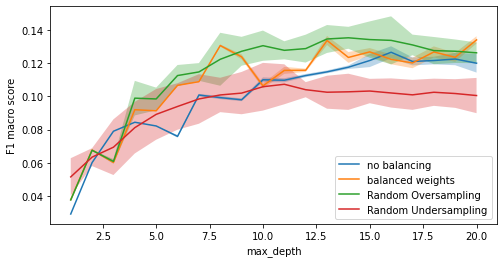

In [85]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

plt.figure(figsize=(8, 4))
#outlier removal
od_clf = LocalOutlierFactor(novelty=True).fit(X_train)
inliers_train = np.argsort(od_clf.decision_function(X_train))[int(outlier_fraction*len(X_train)):]
X_train_OD, y_train_OD = X_train[inliers_train], y_train[inliers_train]
print(len(X_train), ' -> ', len(X_train_OD))

md_range = range(1, 21)
for sampler_class in [None, 'balanced', RandomOverSampler, RandomUnderSampler]:
    evaluate_clf(DecisionTreeClassifier, [{'max_depth': i} for i in md_range], 
                 X_train_OD, y_train_OD, X_test, y_test, n_trials=5, sampler_class=sampler_class)
plt.legend(['no balancing', 'balanced weights', 'Random Oversampling', 'Random Undersampling'])
plt.show()